In [1]:
import pandas as pd
import numpy as np
import re
from gensim import corpora, models, similarities, matutils
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import time

from gensim.models import Word2Vec
  

import numpy as np 
  
from sklearn import cluster
from sklearn import metrics
from textblob import TextBlob
from googletrans import Translator
translator = Translator()

In [70]:
df = pd.read_csv('New_Reviews_Data.csv')
df=df[["review", "stars","product_id"]]


df

,review,stars,product_id
0,Ottimo,5,2.806230e+11
1,Can't tell the difference between the 3 settings,1,4.041600e+10
2,This app is horrible. It does not connect to ...,1,2.808510e+11
3,Nice app and would be great if can remember my...,4,2.815580e+11
4,Als ik de instelling aanpas is het te schel vo...,1,4.038078e+10
...,...,...,...
995,biggest problem when you close the app is that...,3,2.805900e+11
996,Passiert nix. Grauer Bildschirm.,1,2.711010e+11
997,Nice experience.,4,4.041573e+10
998,Ganz schlechtes App,1,2.807070e+11


In [71]:




#df_en = df.copy()

df_en=df.copy()
df_en=df_en.dropna()

df['review']=df_en['review']
df_en
df

,review,stars,product_id
0,Ottimo,5,2.806230e+11
1,Can't tell the difference between the 3 settings,1,4.041600e+10
2,This app is horrible. It does not connect to ...,1,2.808510e+11
3,Nice app and would be great if can remember my...,4,2.815580e+11
4,Als ik de instelling aanpas is het te schel vo...,1,4.038078e+10
...,...,...,...
995,biggest problem when you close the app is that...,3,2.805900e+11
996,Passiert nix. Grauer Bildschirm.,1,2.711010e+11
997,Nice experience.,4,4.041573e+10
998,Ganz schlechtes App,1,2.807070e+11


In [39]:
# translate columns' name using rename function
translator = Translator()

df_en.rename(columns=lambda x: translator.translate(x).text, inplace=True)
df_en.columns

df_en[:100]

,review,stars,product_id
0,Ottimo,5,2.806230e+11
1,Can't tell the difference between the 3 settings,1,4.041600e+10
2,This app is horrible. It does not connect to ...,1,2.808510e+11
3,Nice app and would be great if can remember my...,4,2.815580e+11
4,Als ik de instelling aanpas is het te schel vo...,1,4.038078e+10
...,...,...,...
95,I have the Samsung Note 8 and this app works f...,5,2.805900e+11
96,Worked ok.,4,2.807120e+11
97,"Fungerer ikke, har Huawei. Den gamle appen var...",1,2.805900e+11
98,"Ever since this app was updated, I've lost con...",1,2.711010e+11


In [40]:
translations = {}


for column in df_en.columns:
    # unique elements of the column
    unique_elements = df_en['review'].unique()
    for element in unique_elements:
        # add translation to the dictionary
        translations[element] = translator.translate(element).text
        
    
print(translations)




{'Ottimo': 'Great', "Can't tell the difference between the 3 settings": "Can't tell the difference between the 3 settings", 'This app is horrible.  It does not connect to phone very often & therefore causes major issues.  I may ask for refund on $8k hearing aids if this isnâ€™t fix this next weekðŸ˜ŸðŸ˜ŸðŸ™\x81': 'This app is horrible.  It does not connect to phone very often & therefore causes major issues.  I may ask for refund on $8k hearing aids if this isnâ€™t fix this next weekðŸ˜ŸðŸ˜ŸðŸ™\x81', 'Nice app and would be great if can remember my settings (ex. volume and sound balance).': 'Nice app and would be great if can remember my settings (ex. volume and sound balance).', 'Als ik de instelling aanpas is het te schel voor mijn vrouw, die de hoorapparaten draagt. Als ik ook nog draadloze oortjes gebruik werkt de app niet meer waarvoor hij bedoeld is. Jammerlijk slechte app!': 'When I adjust the setting it is too shrill for my wife who wears the hearing aids. If I also use wireless

In [75]:

df_en.replace(translations, inplace = True)

# check translation
df_en['original_review']=df['review']
df_en[:200]
#df_en.to_csv('Final_translated.csv', index=False)

,review,stars,product_id,original_review
0,Great,5,2.806230e+11,Ottimo
1,Can't tell the difference between the 3 settings,1,4.041600e+10,Can't tell the difference between the 3 settings
2,This app is horrible. It does not connect to ...,1,2.808510e+11,This app is horrible. It does not connect to ...
3,Nice app and would be great if can remember my...,4,2.815580e+11,Nice app and would be great if can remember my...
4,When I adjust the setting it is too shrill for...,1,4.038078e+10,Als ik de instelling aanpas is het te schel vo...
...,...,...,...,...
195,The hearing aid is as previously pointed out w...,1,2.801820e+11,"HÃ¶rapparaten Ã¤r som tidigare pÃ¥pekats bra, ..."
196,The functions on the iPad are OK.\nThe older m...,3,4.019572e+10,Die Funktionen auf dem iPad sind i.O.\nMit dem...
197,"It does not work for Xiaomi mi mobile max 2, p...",1,2.805900e+11,No funciona para el mÃ³vil de Xiaomi mi mÃ¡x 2...
198,I use a Xiaomi mobile phone and the app only o...,1,2.807070e+11,Ich benutze ein Xiaomi Handy und die App biete...


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
# Product Scores
fig = px.histogram(df_en, x="stars")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Reviews Score')
fig.show()

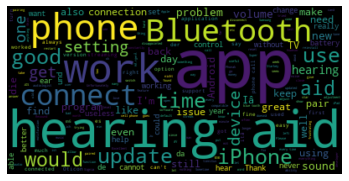

In [43]:

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud 
# Create stopword list:
stopwords = set(stopwords.words('english'))
stopwords.update(["br", "href"])
textt = " ".join(review for review in df_en.review)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

#plt.savefig('wordcloud11.png')
plt.show()

In [44]:
# assign reviews with score > 3 as positive sentiment
# score < 3 negative sentiment
# remove score = 3
df_en = df_en[df_en['stars'] != 3]
df_en['sentiment'] = df_en['stars'].apply(lambda rating : +1 if rating > 3 else -1)

In [45]:
# split df - positive and negative sentiment:
positive = df_en[df_en['sentiment'] == 1]
negative = df_en[df_en['sentiment'] == -1]

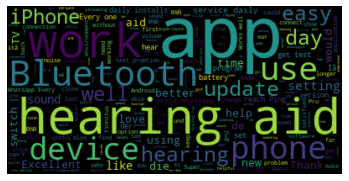

In [46]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
stopwords.update(["br", "href","good","great"]) 
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.review)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

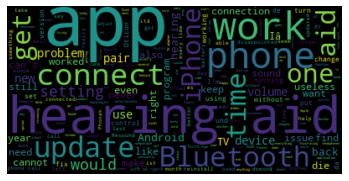

In [47]:
neg = " ".join(review for review in negative.review)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud33.png')
plt.show()

In [48]:
df_en['sentimentt'] = df_en['sentiment'].replace({-1 : 'negative'})
df_en['sentimentt'] = df_en['sentimentt'].replace({1 : 'positive'})
fig = px.histogram(df_en, x="sentimentt")
fig.update_traces(marker_color="indianred",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Sentiment')
fig.show()

In [49]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
df=df_en.copy()
df['clean_review'] = df['review'].str.replace('[^\w\s]','')
df ['clean_review'] = df['clean_review'].astype(str).str.lower()
df['clean_review'] = df['clean_review'].apply(word_tokenize)
df['clean_review'] =df['clean_review'].apply(lambda x: [item for item in x if item not in stopwords.words('english')])
df['clean_review'] = [' '.join(map(str, indStem)) for indStem in df['clean_review']]
df

,review,stars,product_id,original_review,sentiment,sentimentt,clean_review
0,Great,5,2.806230e+11,Ottimo,1,positive,great
1,Can't tell the difference between the 3 settings,1,4.041600e+10,Can't tell the difference between the 3 settings,-1,negative,cant tell difference 3 settings
2,This app is horrible. It does not connect to ...,1,2.808510e+11,This app is horrible. It does not connect to ...,-1,negative,app horrible connect phone often therefore cau...
3,Nice app and would be great if can remember my...,4,2.815580e+11,Nice app and would be great if can remember my...,1,positive,nice app would great remember settings ex volu...
4,When I adjust the setting it is too shrill for...,1,4.038078e+10,Als ik de instelling aanpas is het te schel vo...,-1,negative,adjust setting shrill wife wears hearing aids ...
...,...,...,...,...,...,...,...
994,"Unable to connect to both hearing aids, as men...",2,2.805900e+11,"Unable to connect to both hearing aids, as men...",-1,negative,unable connect hearing aids mentioned many users
996,Passiert nix. Grauer Bildschirm.,1,2.711010e+11,Passiert nix. Grauer Bildschirm.,-1,negative,passiert nix grauer bildschirm
997,Nice experience.,4,4.041573e+10,Nice experience.,1,positive,nice experience
998,Ganz schlechtes App,1,2.807070e+11,Ganz schlechtes App,-1,negative,ganz schlechtes app


In [50]:
dfNew = df[['clean_review','sentiment']]
dfNew.head()

,clean_review,sentiment
0,great,1
1,cant tell difference 3 settings,-1
2,app horrible connect phone often therefore cau...,-1
3,nice app would great remember settings ex volu...,1
4,adjust setting shrill wife wears hearing aids ...,-1


In [51]:
# random split train and test data
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]
df

,review,stars,product_id,original_review,sentiment,sentimentt,clean_review,random_number
0,Great,5,2.806230e+11,Ottimo,1,positive,great,0.037137
1,Can't tell the difference between the 3 settings,1,4.041600e+10,Can't tell the difference between the 3 settings,-1,negative,cant tell difference 3 settings,0.331023
2,This app is horrible. It does not connect to ...,1,2.808510e+11,This app is horrible. It does not connect to ...,-1,negative,app horrible connect phone often therefore cau...,-0.040810
3,Nice app and would be great if can remember my...,4,2.815580e+11,Nice app and would be great if can remember my...,1,positive,nice app would great remember settings ex volu...,1.541714
4,When I adjust the setting it is too shrill for...,1,4.038078e+10,Als ik de instelling aanpas is het te schel vo...,-1,negative,adjust setting shrill wife wears hearing aids ...,1.052504
...,...,...,...,...,...,...,...,...
994,"Unable to connect to both hearing aids, as men...",2,2.805900e+11,"Unable to connect to both hearing aids, as men...",-1,negative,unable connect hearing aids mentioned many users,-0.081937
996,Passiert nix. Grauer Bildschirm.,1,2.711010e+11,Passiert nix. Grauer Bildschirm.,-1,negative,passiert nix grauer bildschirm,-3.163248
997,Nice experience.,4,4.041573e+10,Nice experience.,1,positive,nice experience,2.553890
998,Ganz schlechtes App,1,2.807070e+11,Ganz schlechtes App,-1,negative,ganz schlechtes app,-0.671138


In [62]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['clean_review'])
test_matrix = vectorizer.transform(test['clean_review'])



In [53]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']


In [54]:
lr.fit(X_train,y_train)

LogisticRegression()

In [55]:
predictions = lr.predict(X_test)

In [56]:
from sklearn.metrics import confusion_matrix,classification_report
#new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[95, 15],
       [28, 72]], dtype=int64)

In [57]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.77      0.86      0.82       110
           1       0.83      0.72      0.77       100

    accuracy                           0.80       210
   macro avg       0.80      0.79      0.79       210
weighted avg       0.80      0.80      0.79       210



array([ 1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,
       -1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1,  1,
        1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,
        1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1,
        1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1, -1,
        1, -1, -1,  1,  1,  1], dtype=int64)